In [2]:
# import
from math import sqrt
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from scipy.spatial import distance

In [3]:
# load dataset
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

* Data Exploration

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Fare ranges between 0 - 512.3
* Pclass could be modeled as a categorical feature

In [7]:
print(f"Pclass n of unique values: {df_train['Pclass'].nunique()}")
print(f"Pclass unique values: {df_train['Pclass'].unique()}")

Pclass n of unique values: 3
Pclass unique values: [3 1 2]


In [8]:
df_train['Pclass'] = df_train['Pclass'].map({1:'Upper', 2:'Middle', 3:'Lower'})
df_test['Pclass'] = df_test['Pclass'].map({1:'Upper', 2:'Middle', 3:'Lower'})

* Pclass has 3 unique values (1: Upper Class, 2: Middle Class, 3: Lower Class)
* Translate it into a categorical feature

In [9]:
df_train.select_dtypes(include = 'object').nunique()

Pclass        3
Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64

In [12]:
df_train['Embarked'] = df_train['Embarked'].map({'C':'Cherbourg', 'Q':'Queenstown', 'S':'Southampton'})
df_test['Embarked'] = df_test['Embarked'].map({'C':'Cherbourg', 'Q':'Queenstown', 'S':'Southampton'})

* Sex is defined in the data documentary as female, male
* Embarked can be mapped according to data documentation (C = Cherbourg, Q = Queenstown, S = Southampton)
for better readablity

In [13]:
df_train['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [14]:
df_train['Name'].duplicated().any()

False

* Name is mostly unstructured text
* There are no duplicates in the train set
* The title (Mr., Ms., etc) is contained in the name

In [15]:
df_train.isnull().sum().sort_values(ascending = False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

* Cabin and Age have maximum NaN count
* Cabin should be removed in Pre Processing
* Age should be cleared in Pre Processing, as it important for model building
* Embarked should be cleared in Pre Processing


Data Visualization

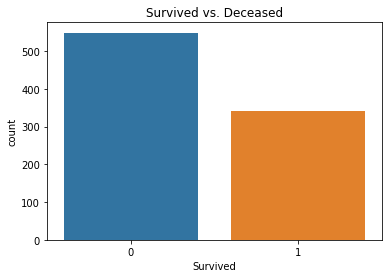

In [16]:
# survived
sns.countplot(x = df_train['Survived']).set_title('Survived vs. Deceased');

Over a third of the people survied

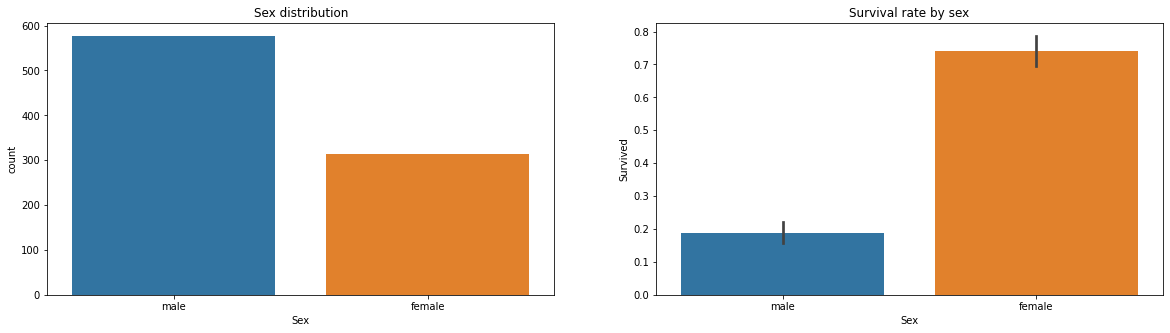

In [18]:
# Sex
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.countplot(ax = axes[0], x = df_train['Sex']).set_title('Sex distribution')
sns.barplot(ax = axes[1], data = df_train, x = "Sex", y = "Survived").set_title('Survival rate by sex');

*   Most travelers were male
*   The survival rate for females is higher


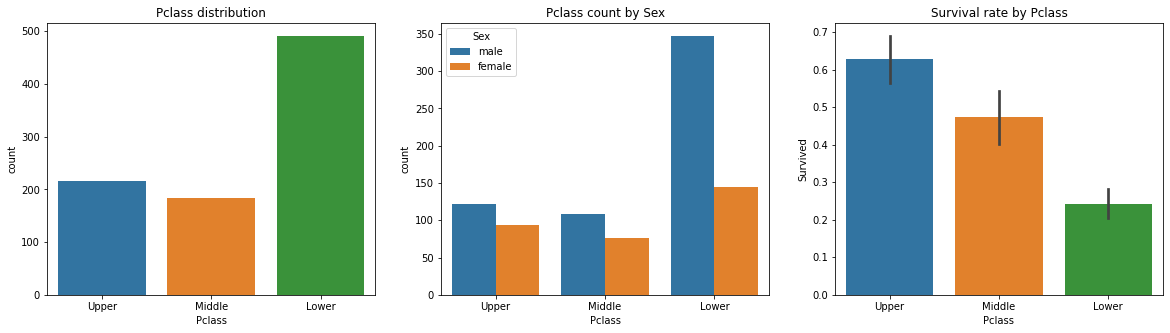

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
pclass_order = ["Upper", "Middle", "Lower"]
sns.countplot(ax = axes[0], x = df_train['Pclass'], order = pclass_order).set_title('Pclass distribution')
sns.countplot(ax = axes[1], data = df_train, x = 'Pclass', order = pclass_order, hue = 'Sex').set_title('Pclass count by Sex')
sns.barplot(ax = axes[2], data = df_train, x = "Pclass", y = "Survived", order = pclass_order).set_title('Survival rate by Pclass');

*   Most travelers were in the lower class
*   Chance of survival grows with class


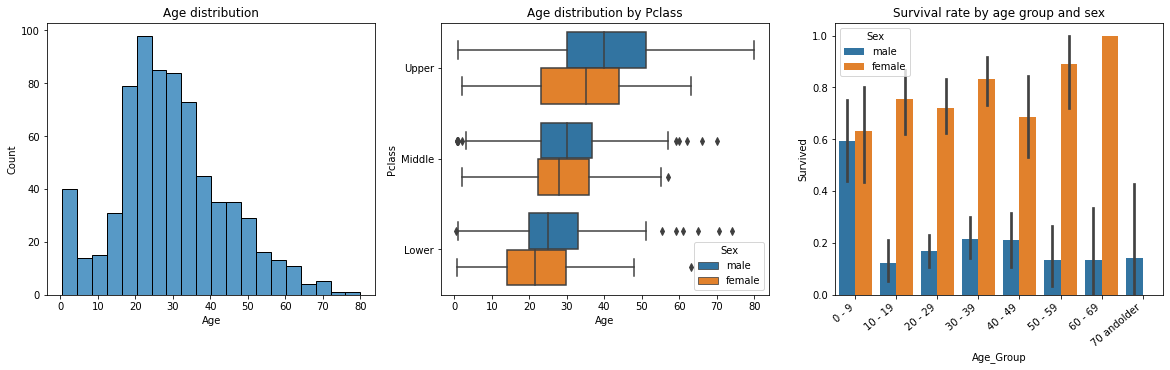

In [22]:
# Age
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.histplot(ax = axes[0], data=df_train, x="Age").set_title('Age distribution')
sns.boxplot(ax = axes[1], data=df_train, x="Age", y="Pclass", hue='Sex', order=["Upper", "Middle", "Lower"]).set_title('Age distribution by Pclass')
#Plot by age group
#Define age limit for groups and their labels
age_groups_thresholds = [0, 9, 19, 29, 39, 49, 59, 69, np.inf]
age_groups = ["0 - 9", "10 - 19", "20 - 29", "30 - 39", "40 - 49", "50 - 59", "60 - 69", "70 andolder"]
#Cut Age Series by thresholds and load into new feature
df_train["Age_Group"] = pd.cut(df_train['Age'], age_groups_thresholds, labels=age_groups)
sns.barplot(ax = axes[2], data=df_train, x="Age_Group", y="Survived", hue="Sex").set_title('Survival rate by age group and sex')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation = 40, ha="right");

*   The Age is normally distributed with a positive skew
*   For males, children from 0 - 9 had the highest chance of surival
*   Women in all age groups had high survival rate
*   Women of old age had a higher survival rate than girls





Data Pre-processing
*   Fill the missing Age values with their mean
*   Fill the missing Embarked values with backward fill (gets the last avaiable value)


In [23]:
#Train data
age_mean = df_train['Age'].mean()
df_train['Age'].fillna(round(age_mean),inplace=True)
df_train['Embarked'].fillna(method = 'bfill', inplace = True)

In [24]:
#Test data
age_mean_test = df_test['Age'].mean()
df_test['Age'].fillna(round(age_mean_test),inplace=True)
df_test['Embarked'].fillna(method = 'bfill', inplace = True)

Data normalization


*   Numeric data - standardize it by normalizing the min max to be inbetween 0 and 1
*   Categorical data - One Hot Encoding



In [25]:
#Scale all numeric features to 0 - 1
def scale(num_features):
 min_max_scaler = MinMaxScaler()
 num_features = min_max_scaler.fit_transform(num_features)
 return pd.DataFrame(num_features)
#One hot encode categorical features
def one_hot_encode(cat_features):
 one_hot_enc = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
 cat_features_one_hot = pd.DataFrame(one_hot_enc.fit_transform(cat_features))
 return pd.DataFrame(cat_features_one_hot)
#Normalize data according to data type
def normalize_data(df):
 cat_features = df.select_dtypes(include = 'object')
 num_features = df.select_dtypes(exclude = 'object')
 cat_features = one_hot_encode(cat_features)
 num_features = scale(num_features)
 df = pd.concat([num_features, cat_features], axis = 1)
 return df.to_numpy()

Splitting the data into training and testing dataset

In [27]:
#Training
X = df_train[['Age', 'Fare', 'SibSp', 'Parch', 'Sex', 'Pclass', 'Embarked']]
X = normalize_data(X)
y = df_train['Survived'].to_numpy()
X_train, X_dev, y_train, y_dev = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 0)

In [28]:
#Testing
X_test = df_test[['Age', 'Fare', 'SibSp', 'Parch', 'Sex', 'Pclass', 'Embarked']]
X_test = normalize_data(X_test)

Model building

In [29]:
class KNearestNeighbourEstimatorVect():
 def __init__(self, k_):
  self.k_ = k_
 def fit(self, X, y):
  self.X_ = X
  self.y_ = y
 def predict(self, X):
  distances = distance.cdist(X, self.X_, 'euclidean')
  i_k_smallest = np.argpartition(distances, self.k_)[:,:self.k_]
  values = self.y_[i_k_smallest]
  predictions = np.average(values, axis=1) > 0.5
  return 1*predictions

In [31]:
m = len(y_train)
best_accuracy = float('-inf')
best_k = -1
for k in range(1, m):
 knn_estimator = KNearestNeighbourEstimatorVect(k_ = k)
 knn_estimator.fit(X_train, y_train)
 y_pred = knn_estimator.predict(X_dev)
 accuracy = accuracy_score(y_dev, y_pred)
 if accuracy > best_accuracy:
  best_accuracy = accuracy
  best_k = k
  best_y_pred = y_pred
print(f'Best k: {best_k}')
print(f'Score: {round(best_accuracy, 2)}')


Best k: 76
Score: 0.83


In [32]:
confusion_m = confusion_matrix(y_dev, best_y_pred)
confusion_m

array([[108,   2],
       [ 28,  41]])

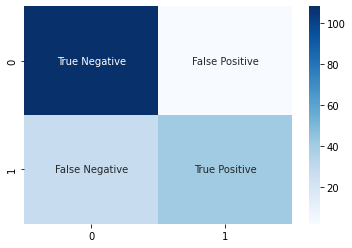

In [33]:
labels = ['True Negative','False Positive','False Negative','True Positive']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_m, annot = labels, fmt = '', cmap = 'Blues');